 Usando dispositivo: cpu
 PINN PROBLEMA INVERSO: IDENTIFICACI√ìN DE PAR√ÅMETROS

 OBJETIVO: Identificar difusividad t√©rmica Œ± desconocida
 ECUACI√ìN: ‚àÇu/‚àÇt = Œ± ‚àÇ¬≤u/‚àÇx¬≤
 ENTRADA: Datos experimentales de temperatura dispersos
 SALIDA: Œ± identificado + soluci√≥n completa u(x,t)

 Generando datos experimentales sint√©ticos...
    50 mediciones experimentales generadas
    Valor verdadero Œ± = 0.25
    Ruido experimental: 2%

 Creando modelo PINN inverso...
    Par√°metros de red: 5302
    Œ± inicial: 1.000000

 Entrenando PINN...
 Iniciando entrenamiento de PINN inversa...
 Valor verdadero de Œ±: 0.25
 Valor inicial de Œ±: 1.000000
------------------------------------------------------------
√âpoca    0 | P√©rdida: 0.590727 | Œ±_pred: 0.999000 | Error Œ±: 0.749000
√âpoca  500 | P√©rdida: 0.025708 | Œ±_pred: 0.589930 | Error Œ±: 0.339930
√âpoca 1000 | P√©rdida: 0.007489 | Œ±_pred: 0.395693 | Error Œ±: 0.145693
√âpoca 1500 | P√©rdida: 0.001935 | Œ±_pred: 0.304776 | Error Œ±: 0.

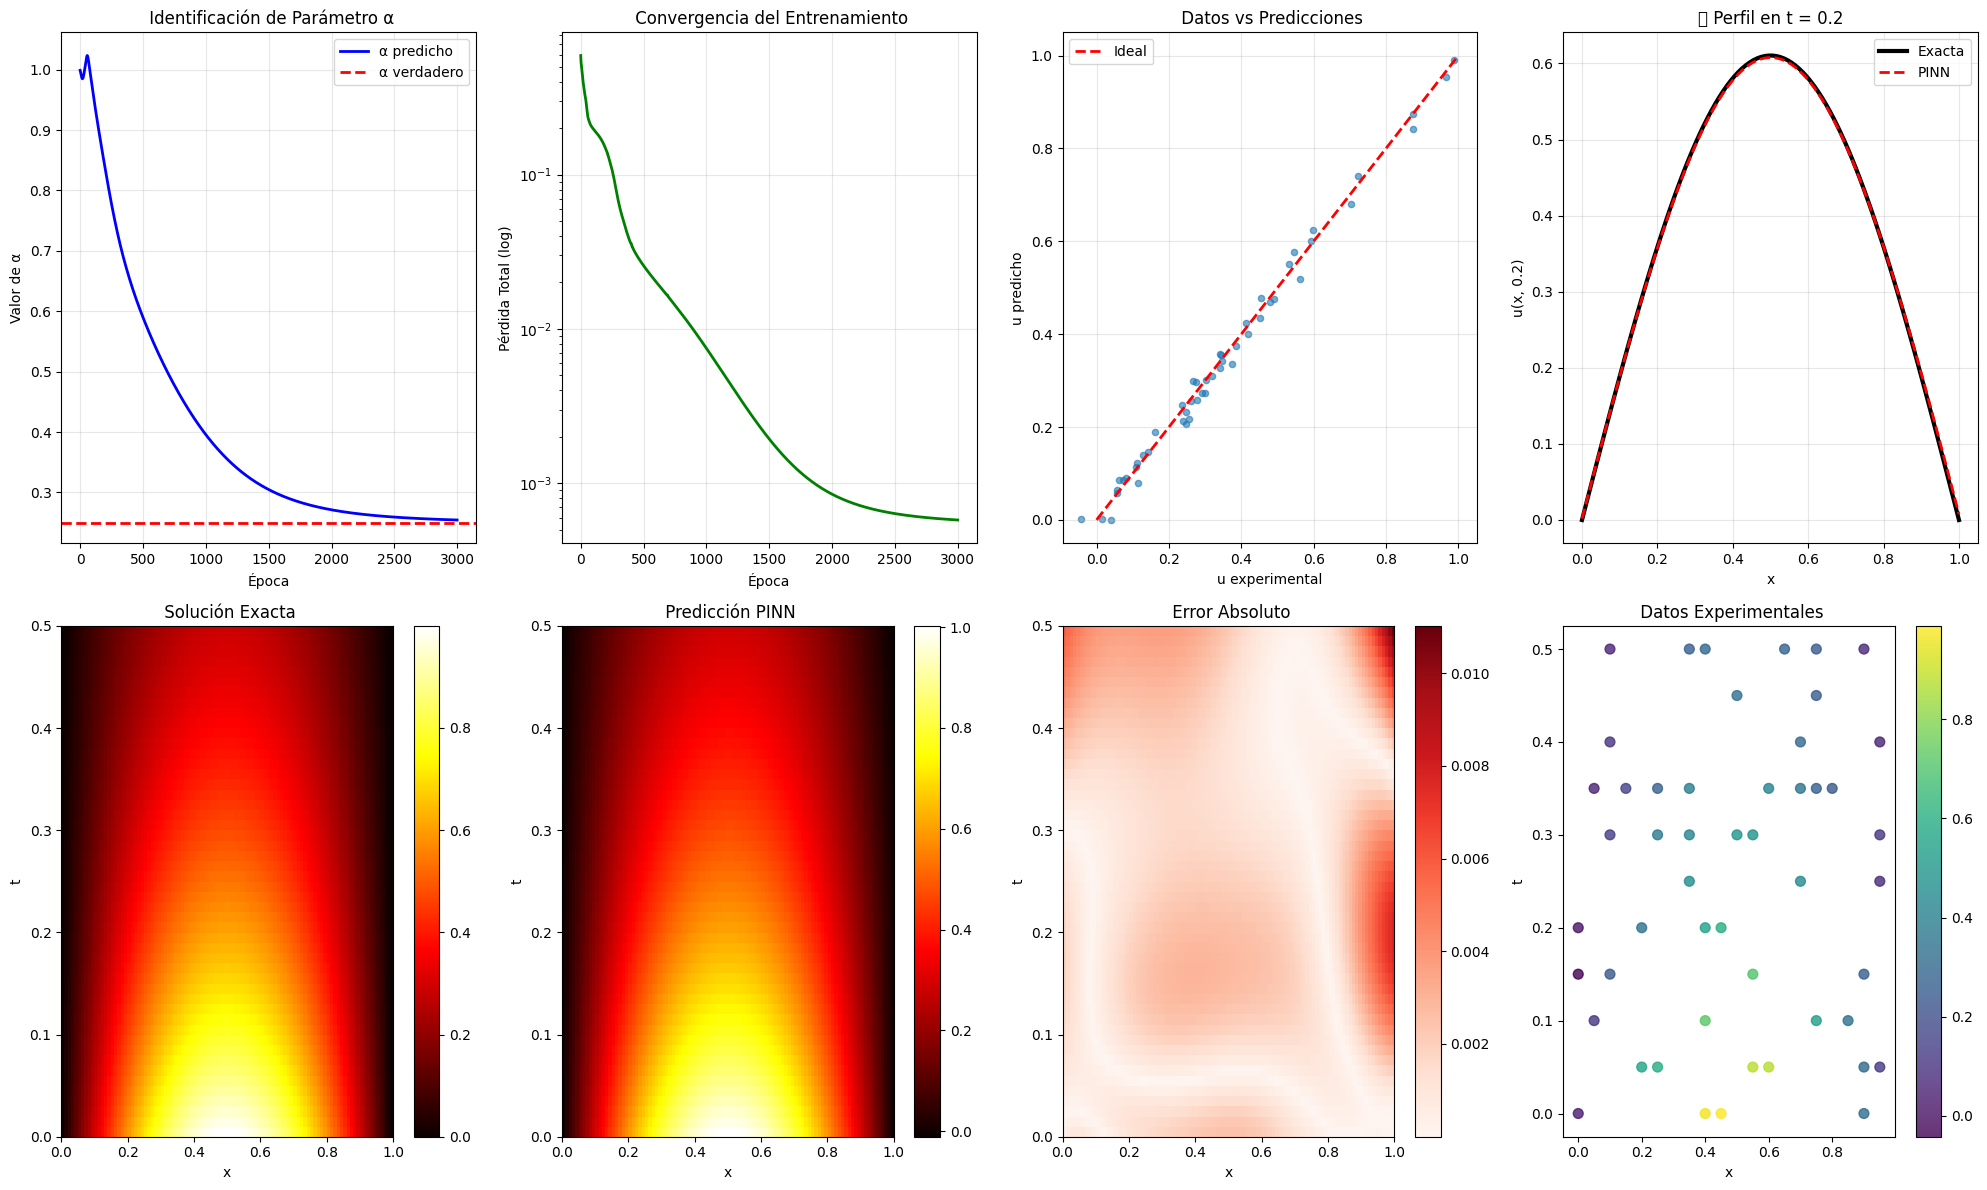


 LIMITACI√ìN DE M√âTODOS TRADICIONALES

 DIFERENCIAS FINITAS para problema inverso:
   ‚àÇu/‚àÇt = Œ± ‚àÇ¬≤u/‚àÇx¬≤

    PROBLEMA: Necesita Œ± conocido de antemano
    Sin Œ±, no puede construir las ecuaciones
    Requiere proceso iterativo costoso:
      1. Adivinar Œ±
      2. Resolver PDE completa
      3. Comparar con datos
      4. Ajustar Œ± y repetir

 PINN RESUELVE AUTOM√ÅTICAMENTE:
    Identifica Œ± y u(x,t) simult√°neamente
    Una sola optimizaci√≥n
    Incorpora datos experimentales directamente

 RESUMEN FINAL
 Œ± identificado correctamente: 0.254349
 Error en Œ±: 1.74%
 Precisi√≥n de soluci√≥n L2: 0.002145
 Tiempo total: 55.19 segundos

 VENTAJA CLAVE DE PINNs:
   ‚Ä¢ Identificaci√≥n autom√°tica de par√°metros
   ‚Ä¢ Incorporaci√≥n directa de datos experimentales


In [2]:
"""
=============================================================================
PHYSICS-INFORMED NEURAL NETWORKS: PROBLEMA INVERSO
Identificaci√≥n de Par√°metros - Difusividad T√©rmica Desconocida
=============================================================================

PROBLEMA: Ecuaci√≥n de calor con Œ± desconocida
‚àÇu/‚àÇt = Œ± ‚àÇ¬≤u/‚àÇx¬≤

VENTAJA DE PINNs: Identifica Œ± a partir de datos experimentales

"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import time
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Usando dispositivo: {device}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

class InversePINN(nn.Module):
    """
    Physics-Informed Neural Network para Problema Inverso

    Caracter√≠sticas:
    - Aproxima u(x,t) con red neuronal
    - Identifica par√°metro Œ± desconocido
    - Incorpora f√≠sica y datos experimentales simult√°neamente
    """

    def __init__(self, layers=[2, 50, 50, 50, 1]):
        super().__init__()

        # ARQUITECTURA DE RED NEURONAL
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

        # PAR√ÅMETRO DESCONOCIDO A IDENTIFICAR
        # Œ±_true = 0.25, pero la red no lo sabe
        self.alpha = nn.Parameter(torch.tensor(1.0, device=device))

        # Inicializaci√≥n Xavier para estabilidad
        for layer in self.layers[:-1]:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x, t):
        """
        Red neuronal: u(x,t) = NN(x,t)
        """
        inputs = torch.cat([x, t], dim=1)

        for i, layer in enumerate(self.layers[:-1]):
            inputs = torch.tanh(layer(inputs))

        # Capa final sin activaci√≥n
        u = self.layers[-1](inputs)
        return u

    def physics_residual(self, x, t):
        """
        Calcula residuo de la ecuaci√≥n f√≠sica:
        R = ‚àÇu/‚àÇt - Œ± ‚àÇ¬≤u/‚àÇx¬≤

        Si R ‚âà 0 en todos los puntos, la red satisface la f√≠sica
        """
        # Habilitar gradientes para diferenciaci√≥n autom√°tica
        x.requires_grad_(True)
        t.requires_grad_(True)

        u = self(x, t)

        # Primera derivada temporal: ‚àÇu/‚àÇt
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

        # Primera derivada espacial: ‚àÇu/‚àÇx
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

        # Segunda derivada espacial: ‚àÇ¬≤u/‚àÇx¬≤
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

        # ECUACI√ìN F√çSICA: ‚àÇu/‚àÇt = Œ± ‚àÇ¬≤u/‚àÇx¬≤
        residual = u_t - self.alpha * u_xx

        return residual

def generate_synthetic_data():
    """
    Genera datos sint√©ticos usando la soluci√≥n anal√≠tica
    con Œ±_true = 0.25 (valor que queremos recuperar)

    Soluci√≥n exacta: u(x,t) = exp(-Œ± œÄ¬≤ t) sin(œÄ x)
    """

    alpha_true = 0.25  #  VALOR VERDADERO A IDENTIFICAR

    # Dominio espacial y temporal
    x_data = torch.linspace(0, 1, 21).reshape(-1, 1)  # 21 puntos espaciales
    t_data = torch.linspace(0, 0.5, 11).reshape(-1, 1)  # 11 puntos temporales

    # Malla completa
    X_data, T_data = torch.meshgrid(x_data.squeeze(), t_data.squeeze(), indexing='ij')
    x_flat = X_data.flatten().reshape(-1, 1)
    t_flat = T_data.flatten().reshape(-1, 1)

    #  SOLUCI√ìN ANAL√çTICA EXACTA
    u_exact = torch.exp(-alpha_true * np.pi**2 * t_flat) * torch.sin(np.pi * x_flat)

    #  SIMULAR DATOS EXPERIMENTALES (con ruido)
    noise_level = 0.02  # 2% de ruido experimental
    noise = noise_level * torch.randn_like(u_exact)
    u_experimental = u_exact + noise

    # Seleccionar subset de datos experimentales (datos dispersos)
    n_data = 50  # Solo 50 mediciones de 231 posibles
    indices = torch.randperm(len(x_flat))[:n_data]

    x_exp = x_flat[indices].to(device)
    t_exp = t_flat[indices].to(device)
    u_exp = u_experimental[indices].to(device)

    return x_exp, t_exp, u_exp, alpha_true, x_flat, t_flat, u_exact

def train_inverse_pinn(model, x_exp, t_exp, u_exp, epochs=3000):
    """
    Entrena la PINN para problema inverso

    Funci√≥n de p√©rdida multi-objetivo:
    L_total = Œª‚ÇÅ L_data + Œª‚ÇÇ L_physics + Œª‚ÇÉ L_ic + Œª‚ÇÑ L_bc
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

    # Puntos de colocaci√≥n para f√≠sica
    n_physics = 1000
    x_physics = torch.rand(n_physics, 1, device=device)
    t_physics = torch.rand(n_physics, 1, device=device) * 0.5

    # Condiciones de frontera e inicial
    n_boundary = 100

    # Condici√≥n inicial: t = 0
    x_ic = torch.rand(n_boundary, 1, device=device)
    t_ic = torch.zeros(n_boundary, 1, device=device)
    u_ic = torch.sin(np.pi * x_ic)  # u(x,0) = sin(œÄx)

    # Condiciones de frontera: u(0,t) = u(1,t) = 0
    t_bc = torch.rand(n_boundary, 1, device=device) * 0.5
    x_bc1 = torch.zeros(n_boundary, 1, device=device)  # x = 0
    x_bc2 = torch.ones(n_boundary, 1, device=device)   # x = 1

    # Almacenar historia del entrenamiento
    losses = []
    alpha_history = []

    print(" Iniciando entrenamiento de PINN inversa...")
    print(f" Valor verdadero de Œ±: 0.25")
    print(f" Valor inicial de Œ±: {model.alpha.item():.6f}")
    print("-" * 60)

    start_time = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()

        #  P√âRDIDA DE DATOS EXPERIMENTALES
        u_pred_data = model(x_exp, t_exp)
        loss_data = torch.mean((u_pred_data - u_exp)**2)

        #  P√âRDIDA F√çSICA (residuo de PDE)
        residual = model.physics_residual(x_physics, t_physics)
        loss_physics = torch.mean(residual**2)

        #  P√âRDIDA CONDICI√ìN INICIAL
        u_pred_ic = model(x_ic, t_ic)
        loss_ic = torch.mean((u_pred_ic - u_ic)**2)

        #  P√âRDIDA CONDICIONES DE FRONTERA
        u_pred_bc1 = model(x_bc1, t_bc)
        u_pred_bc2 = model(x_bc2, t_bc)
        loss_bc = torch.mean(u_pred_bc1**2 + u_pred_bc2**2)

        #  P√âRDIDA TOTAL PONDERADA
        lambda_data = 1.0      # Peso datos experimentales
        lambda_physics = 0.1   # Peso f√≠sica
        lambda_ic = 1.0        # Peso condici√≥n inicial
        lambda_bc = 1.0        # Peso condiciones frontera

        loss_total = (lambda_data * loss_data +
                     lambda_physics * loss_physics +
                     lambda_ic * loss_ic +
                     lambda_bc * loss_bc)

        # Backpropagation
        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Guardar historia
        losses.append(loss_total.item())
        alpha_history.append(model.alpha.item())

        # Progreso cada 500 √©pocas
        if epoch % 500 == 0:
            print(f"√âpoca {epoch:4d} | "
                  f"P√©rdida: {loss_total.item():.6f} | "
                  f"Œ±_pred: {model.alpha.item():.6f} | "
                  f"Error Œ±: {abs(model.alpha.item() - 0.25):.6f}")

    training_time = time.time() - start_time

    print("-" * 60)
    print(f" Entrenamiento completado en {training_time:.2f} segundos")
    print(f" Œ±_verdadero = 0.25")
    print(f" Œ±_predicho  = {model.alpha.item():.6f}")
    print(f" Error relativo = {abs(model.alpha.item() - 0.25) / 0.25 * 100:.2f}%")

    return losses, alpha_history, training_time

def evaluate_and_visualize(model, x_exp, t_exp, u_exp, alpha_true,
                          x_flat, t_flat, u_exact, losses, alpha_history):
    """
    Evaluaci√≥n completa y visualizaci√≥n de resultados
    """

    print("\n" + "="*60)
    print(" EVALUACI√ìN DE RESULTADOS")
    print("="*60)

    # Evaluaci√≥n en malla fina para visualizaci√≥n
    x_test = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
    t_test = torch.linspace(0, 0.5, 50).reshape(-1, 1).to(device)
    X_test, T_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_eval = X_test.flatten().reshape(-1, 1)
    t_eval = T_test.flatten().reshape(-1, 1)

    # Predicciones del modelo
    with torch.no_grad():
        u_pred = model(x_eval, t_eval).cpu()

    # Soluci√≥n exacta en malla fina
    u_exact_eval = np.exp(-alpha_true * np.pi**2 * t_eval.cpu().numpy()) * np.sin(np.pi * x_eval.cpu().numpy())
    u_exact_eval = torch.from_numpy(u_exact_eval).float()

    # M√©tricas de error
    error_l2 = torch.sqrt(torch.mean((u_pred - u_exact_eval)**2))
    error_max = torch.max(torch.abs(u_pred - u_exact_eval))
    error_alpha = abs(model.alpha.item() - alpha_true)
    error_alpha_rel = error_alpha / alpha_true * 100

    print(f" IDENTIFICACI√ìN DE PAR√ÅMETROS:")
    print(f"   Œ± verdadero:  {alpha_true:.6f}")
    print(f"   Œ± predicho:   {model.alpha.item():.6f}")
    print(f"   Error Œ±:      {error_alpha:.6f}")
    print(f"   Error Œ± (%):  {error_alpha_rel:.2f}%")
    print()
    print(f" PRECISI√ìN DE SOLUCI√ìN:")
    print(f"   Error L2:     {error_l2.item():.6f}")
    print(f"   Error m√°ximo: {error_max.item():.6f}")

    # Crear visualizaci√≥n completa
    fig = plt.figure(figsize=(20, 12))

    # 1. Convergencia de Œ± durante entrenamiento
    ax1 = plt.subplot(2, 4, 1)
    plt.plot(alpha_history, 'b-', linewidth=2, label='Œ± predicho')
    plt.axhline(y=alpha_true, color='r', linestyle='--', linewidth=2, label='Œ± verdadero')
    plt.xlabel('√âpoca')
    plt.ylabel('Valor de Œ±')
    plt.title(' Identificaci√≥n de Par√°metro Œ±')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Convergencia de p√©rdida
    ax2 = plt.subplot(2, 4, 2)
    plt.semilogy(losses, 'g-', linewidth=2)
    plt.xlabel('√âpoca')
    plt.ylabel('P√©rdida Total (log)')
    plt.title(' Convergencia del Entrenamiento')
    plt.grid(True, alpha=0.3)

    # 3. Datos experimentales vs predicciones
    ax3 = plt.subplot(2, 4, 3)
    u_pred_exp = model(x_exp, t_exp).detach().cpu()
    plt.scatter(u_exp.cpu(), u_pred_exp, alpha=0.6, s=20)
    plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ideal')
    plt.xlabel('u experimental')
    plt.ylabel('u predicho')
    plt.title(' Datos vs Predicciones')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Perfil de temperatura en t=0.2
    ax4 = plt.subplot(2, 4, 4)
    t_slice = 0.2
    x_slice = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
    t_slice_tensor = torch.full_like(x_slice, t_slice)

    with torch.no_grad():
        u_pred_slice = model(x_slice, t_slice_tensor).cpu()
    u_exact_slice = np.exp(-alpha_true * np.pi**2 * t_slice) * np.sin(np.pi * x_slice.cpu().numpy())

    plt.plot(x_slice.cpu(), u_exact_slice, 'k-', linewidth=3, label='Exacta')
    plt.plot(x_slice.cpu(), u_pred_slice, 'r--', linewidth=2, label='PINN')
    plt.xlabel('x')
    plt.ylabel('u(x, 0.2)')
    plt.title(f'üå°Ô∏è Perfil en t = {t_slice}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5-6. Mapas de calor comparativos
    u_pred_2d = u_pred.reshape(100, 50)
    u_exact_2d = u_exact_eval.reshape(100, 50)

    ax5 = plt.subplot(2, 4, 5)
    im1 = plt.imshow(u_exact_2d.T, extent=[0, 1, 0, 0.5],
                     aspect='auto', origin='lower', cmap='hot')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Soluci√≥n Exacta')
    plt.colorbar(im1, ax=ax5)

    ax6 = plt.subplot(2, 4, 6)
    im2 = plt.imshow(u_pred_2d.T, extent=[0, 1, 0, 0.5],
                     aspect='auto', origin='lower', cmap='hot')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Predicci√≥n PINN')
    plt.colorbar(im2, ax=ax6)

    # 7. Mapa de error
    ax7 = plt.subplot(2, 4, 7)
    error_2d = torch.abs(u_pred_2d - u_exact_2d)
    im3 = plt.imshow(error_2d.T, extent=[0, 1, 0, 0.5],
                     aspect='auto', origin='lower', cmap='Reds')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Error Absoluto')
    plt.colorbar(im3, ax=ax7)

    # 8. Distribuci√≥n de datos experimentales
    ax8 = plt.subplot(2, 4, 8)
    scatter = plt.scatter(x_exp.cpu(), t_exp.cpu(), c=u_exp.cpu(),
                         cmap='viridis', s=50, alpha=0.8)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(' Datos Experimentales')
    plt.colorbar(scatter, ax=ax8)

    plt.tight_layout()
    plt.show()

    return {
        'error_l2': error_l2.item(),
        'error_max': error_max.item(),
        'error_alpha': error_alpha,
        'error_alpha_rel': error_alpha_rel,
        'alpha_predicted': model.alpha.item()
    }

def demonstrate_traditional_method_limitation():
    """
    Demuestra por qu√© los m√©todos tradicionales NO pueden resolver
    el problema inverso directamente
    """

    print("\n" + "="*60)
    print(" LIMITACI√ìN DE M√âTODOS TRADICIONALES")
    print("="*60)
    print()
    print(" DIFERENCIAS FINITAS para problema inverso:")
    print("   ‚àÇu/‚àÇt = Œ± ‚àÇ¬≤u/‚àÇx¬≤")
    print()
    print("    PROBLEMA: Necesita Œ± conocido de antemano")
    print("    Sin Œ±, no puede construir las ecuaciones")
    print("    Requiere proceso iterativo costoso:")
    print("      1. Adivinar Œ±")
    print("      2. Resolver PDE completa")
    print("      3. Comparar con datos")
    print("      4. Ajustar Œ± y repetir")
    print()
    print(" PINN RESUELVE AUTOM√ÅTICAMENTE:")
    print("    Identifica Œ± y u(x,t) simult√°neamente")
    print("    Una sola optimizaci√≥n")
    print("    Incorpora datos experimentales directamente")


def main():
    """
    Funci√≥n principal - Ejecuta el ejemplo completo
    """

    print("="*70)
    print(" PINN PROBLEMA INVERSO: IDENTIFICACI√ìN DE PAR√ÅMETROS")
    print("="*70)
    print()
    print(" OBJETIVO: Identificar difusividad t√©rmica Œ± desconocida")
    print(" ECUACI√ìN: ‚àÇu/‚àÇt = Œ± ‚àÇ¬≤u/‚àÇx¬≤")
    print(" ENTRADA: Datos experimentales de temperatura dispersos")
    print(" SALIDA: Œ± identificado + soluci√≥n completa u(x,t)")
    print()

    # 1. Generar datos sint√©ticos
    print(" Generando datos experimentales sint√©ticos...")
    x_exp, t_exp, u_exp, alpha_true, x_flat, t_flat, u_exact = generate_synthetic_data()

    print(f"    {len(x_exp)} mediciones experimentales generadas")
    print(f"    Valor verdadero Œ± = {alpha_true}")
    print(f"    Ruido experimental: 2%")

    # 2. Crear modelo PINN
    print("\n Creando modelo PINN inverso...")
    model = InversePINN().to(device)
    print(f"    Par√°metros de red: {sum(p.numel() for p in model.parameters())}")
    print(f"    Œ± inicial: {model.alpha.item():.6f}")

    # 3. Entrenar modelo
    print("\n Entrenando PINN...")
    losses, alpha_history, training_time = train_inverse_pinn(
        model, x_exp, t_exp, u_exp, epochs=3000
    )

    # 4. Evaluar y visualizar
    results = evaluate_and_visualize(
        model, x_exp, t_exp, u_exp, alpha_true,
        x_flat, t_flat, u_exact, losses, alpha_history
    )

    # 5. Demostrar limitaci√≥n de m√©todos tradicionales
    demonstrate_traditional_method_limitation()

    # 6. Resumen final
    print("\n" + "="*60)
    print(" RESUMEN FINAL")
    print("="*60)
    print(f" Œ± identificado correctamente: {results['alpha_predicted']:.6f}")
    print(f" Error en Œ±: {results['error_alpha_rel']:.2f}%")
    print(f" Precisi√≥n de soluci√≥n L2: {results['error_l2']:.6f}")
    print(f" Tiempo total: {training_time:.2f} segundos")
    print()
    print(" VENTAJA CLAVE DE PINNs:")
    print("   ‚Ä¢ Identificaci√≥n autom√°tica de par√°metros")
    print("   ‚Ä¢ Incorporaci√≥n directa de datos experimentales")

if __name__ == "__main__":
    main()